In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys, os
import time
from tqdm.autonotebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

<ipython-input-1-074fbbe74481>:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
computed = True # изменение на False изменит портфель акций на актуальный

if computed == False: #получаем список актуальных кампаний
    trending = pd.read_html("https://finance.yahoo.com/markets/stocks/trending/")[0]
    most_active = pd.read_html("https://finance.yahoo.com/markets/stocks/most-active/")[0]
    gainers = pd.read_html("https://finance.yahoo.com/markets/stocks/gainers/")[0]
    losers = pd.read_html("https://finance.yahoo.com/markets/stocks/losers/")[0]
    interesting_tickers = set()
        

    for df in [trending, most_active, gainers, losers]:
        interesting_tickers = interesting_tickers.union(set(df['Symbol'][:10]))
    interesting_tickers = list(interesting_tickers)
    
    for i in range(len(interesting_tickers)):
        if ' ' in interesting_tickers[i]:
            tmp = ''
            j = 0
            while interesting_tickers[i][j] != ' ':
                tmp += interesting_tickers[i][j]
                j += 1
            interesting_tickers[i] = tmp
    
    interesting_tickers.remove('MUSA')
    interesting_tickers.remove('META')
    print(interesting_tickers)
    

In [3]:
# качаем данные найденных кампаний
frames = [] 

data = yf.download(interesting_tickers[0], period='6mo', interval='1h')
dates = data.index.tolist()
dates = [date.strftime('%Y-%m-%d %X') for date in dates]

for ticker in interesting_tickers:
    data = yf.download(ticker, period='6mo', interval='1h')
    data = data.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'],axis=1)
    data = data.rename(columns={'Close':ticker})
    frames.append(data.transpose())

NameError: name 'interesting_tickers' is not defined

In [121]:
#в данных на одни сутки приходится по 7 цен с 9:30 до 15:30, а значит 30 дней это 210 точек
day_interval = 7
month_interval = 210

def window(data, begin): # выделяет окно в 30 дней начиная с дня begin
    new_data = data.iloc[:, begin:begin+month_interval].copy()
    return new_data

def date_to_int(dates, day): # преобразует день, заданный в виде строки, в число -- порядковый номер этого дня
    for j in range(len(dates)):
        tmp = ''
        for i in range(10):
            tmp += dates[j][i]
        if tmp == day:
            return j
    return -1 #в случае если в этот день торгов не было

In [122]:
# собираем данные в один фрейм
full_data = pd.concat(frames)
full_data = full_data.ffill(axis=1)
full_data = full_data.bfill(axis=1)

In [123]:
def scale(full_data_30): # функция для нормирования всех временных рядов
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(full_data_30.T).T
    return scaled_data

In [124]:
# подбор нужного числа кластеров. Я выбрал 4


# distortions = []
# silhouette = []
# K = range(1, 10)
# for k in tqdm(K):
#     kmeanModel = TimeSeriesKMeans(n_clusters=k, metric="dtw", n_jobs=6, max_iter=10)
#     kmeanModel.fit(scaled_data)
#     distortions.append(kmeanModel.inertia_)
#     if k > 1:
#         silhouette.append(silhouette_score(scaled_data, kmeanModel.labels_))

# plt.figure(figsize=(10,4))
# plt.plot(K, distortions, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Distortion')
# plt.title('Elbow Method')
# plt.show()

# plt.figure(figsize=(10,4))
# plt.plot(K[1:], silhouette, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Silhouette score')
# plt.title('Silhouette')
# plt.show()

In [125]:
n_clusters = 4
def clusterization(full_data_30): # кластеризует временные ряды
    scaled_data = scale(full_data_30)
    ts_kmeans_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", n_jobs=6, max_iter=10)
    ts_kmeans_dtw.fit(scaled_data)
    return ts_kmeans_dtw

In [126]:
def plot_centroids(ts_kmeans_dtw): # вывести центроиды кластеров 
    for cluster_number in range(n_clusters):
        plt.plot(ts_kmeans_dtw.cluster_centers_[cluster_number, :, 0].T, label=cluster_number)
    plt.title("Cluster centroids")
    plt.legend()
    plt.show()

In [127]:
def plot_cluster_tickers(full_data_30): # вывести представителя кластера
    for cluster in range(n_clusters):
        print("=================================================================================")
        print(f"                          Cluster number: {cluster}")
        print("=================================================================================")
        current_cluster = full_data_30[full_data_30.cluster==cluster]
        fig, ax = plt.subplots(
            int(np.ceil(current_cluster.shape[0]/4)),
            4,
            figsize=(15, 3*int(np.ceil(current_cluster.shape[0]/4)))
        )
        fig.autofmt_xdate(rotation=45)
        ax = ax.reshape(-1)

        for index, (_, row) in enumerate(current_cluster.iterrows()):
            ax[index].plot(row.iloc[5:-1])
            plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()

In [197]:
def make_features(full_data_30): # создает матрицу признаков
    index = full_data_30.index
    features = pd.DataFrame()
    features.index = index
    scaled_data = scale(full_data_30)
    ts_kmeans_dtw = clusterization(scaled_data)
    features['min'] = full_data_30.min(axis=1)
    features['max'] = full_data_30.max(axis=1)
    features['mean'] = full_data_30.mean(axis=1)
    features['std'] = full_data_30.std(axis=1)
    features['lag1'] = full_data_30.iloc[:,-1]
    features['lag2'] = full_data_30.iloc[:,-2]
    features['lag3'] = full_data_30.iloc[:,-3]
    features['lag4'] = full_data_30.iloc[:,-4]
    features['lag5'] = full_data_30.iloc[:,-5]
    features['movingavg5'] = full_data_30.iloc[:,175:-1].mean(axis=1)
    features['movingavg20'] = full_data_30.iloc[:,70:-1].mean(axis=1)
    features['median'] = full_data_30.median(axis=1)
    ts_kmeans_dtw = clusterization(full_data_30)
    features['cluster'] = ts_kmeans_dtw.predict(scaled_data)
    return features
    
def make_target(data, begin):
    new_data = data.iloc[:, begin+month_interval+1].copy()
    return new_data

In [205]:
day = '2024-03-20'
index = date_to_int(dates,day)
print(index)
full_data_30 = window(full_data,index)
x_train1 = make_features(full_data_30)
y_train1 = make_target(full_data,index)

day = '2024-04-19'
index = date_to_int(dates,day)
print(index)
full_data_30 = window(full_data,index)
x_train2 = make_features(full_data_30)
y_train2 = make_target(full_data,index)

day = '2024-05-20'
index = date_to_int(dates,day)
print(index)
full_data_30 = window(full_data,index)
x_train3 = make_features(full_data_30)
y_train3 = make_target(full_data,index)

day = '2024-06-20'
index = date_to_int(dates,day)
print(index)
full_data_30 = window(full_data,index)
x_train4 = make_features(full_data_30)
y_train4 = make_target(full_data,index)


x_train = pd.concat([x_train1,x_train2,x_train3,x_train4])
y_train = pd.concat([y_train1,y_train2,y_train3,y_train4])

6


C:\Users\User\anaconda3\lib\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 33 1-dimensional timeseries
  warnings.warn(


153


C:\Users\User\anaconda3\lib\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 33 1-dimensional timeseries
  warnings.warn(


300


C:\Users\User\anaconda3\lib\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 33 1-dimensional timeseries
  warnings.warn(


447


C:\Users\User\anaconda3\lib\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 33 1-dimensional timeseries
  warnings.warn(


In [199]:
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [215]:
day = '2024-07-19'
index = date_to_int(dates,day)
print(index)
full_data_30 = window(full_data,index)
x_test1 = make_features(full_data_30)
y_test1 = make_target(full_data,index)
y_prev1 = make_target(full_data,index-1)

day = '2024-07-30'
index = date_to_int(dates,day)
print(index)
full_data_30 = window(full_data,index)
x_test2 = make_features(full_data_30)
y_test2 = make_target(full_data,index)
y_prev2 = make_target(full_data,index-1)

day = '2024-08-05'
index = date_to_int(dates,day)
print(index)
full_data_30 = window(full_data,index)
x_test3 = make_features(full_data_30)
y_test3 = make_target(full_data,index)
y_prev3 = make_target(full_data,index-1)

x_test = pd.concat([x_test1,x_test2,x_test3])
y_test = pd.concat([y_test1,y_test2,y_test3])
y_prev = pd.concat([y_prev1,y_prev2,y_prev3])

583


C:\Users\User\anaconda3\lib\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 33 1-dimensional timeseries
  warnings.warn(


632


C:\Users\User\anaconda3\lib\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 33 1-dimensional timeseries
  warnings.warn(


660


C:\Users\User\anaconda3\lib\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 33 1-dimensional timeseries
  warnings.warn(


In [212]:
predict_t = model.predict(x_test)
predict_t = [float(predict) for predict in predict_t]

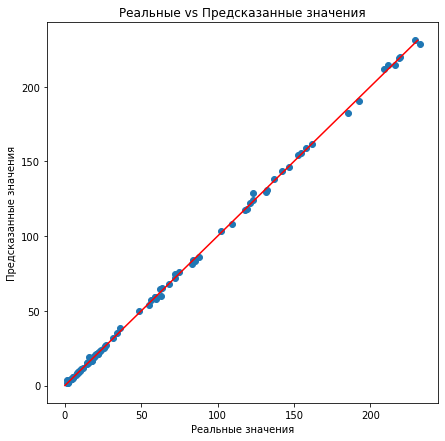

In [213]:
fig, ax = plt.subplots(figsize=(7,7))
plt.scatter(y_test, predict_t)
plt.xlabel("Реальные значения")
plt.ylabel("Предсказанные значения")
plt.title("Реальные vs Предсказанные значения")
A = [i for i in range(round(max(predict_t)))]
plt.plot(A,color='red')
plt.show()

In [217]:
correct_predictions = []
for i in range(len(y_test)):
    if 0.95 * y_prev[i] <= y_test[i] and y_test[i] <= y_prev[i] * 1.05: # цена стабильна
        # предсказание тоже говорит о том что цена стабильна
        if 0.95 * y_prev[i] <= predict_t[i] and predict_t[i] <= y_prev[i] * 1.05:
            correct_predictions.append(1)
        else:
            correct_predictions.append(0)
            
    if 0.95 * y_prev[i] > y_test[i]: # цена упала
        # предсказание тоже говорит о том что цена упала
        if 0.95 * y_prev[i] > predict_t[i]:
            correct_predictions.append(1)
        else:
            correct_predictions.append(0)
    
    if 1.05 * y_prev[i] < y_test[i]: # цена возросла
        # предсказание тоже говорит о том что цена возросла
        if 1.05 * y_prev[i] < predict_t[i]:
            correct_predictions.append(1)
        else:
            correct_predictions.append(0)
print('accuracy   ', sum(correct_predictions)/len(correct_predictions))

accuracy    0.8686868686868687
